<a href="https://colab.research.google.com/github/kw01sg/neural-style-transfer/blob/google-colab/google_colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

In [9]:
tf.__version__

'2.0.0-beta1'

### Utils.py

In [0]:
# utils.py
import numpy as np
from PIL import Image


def load_image(image_path):
    max_dim = 512
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = tf.expand_dims(img, axis=0)

    return img


def save_image(image_array, file_path, format=None):
    """Expect image_array to have shape of n_height * n_width * n_channel
    """

    # PIL fromarray takes in array of dtype 'uint8'
    unsigned_image_array = tf.squeeze(
        image_array, axis=0).numpy().astype('uint8')
    image = Image.fromarray(unsigned_image_array, 'RGB')
    image.save(file_path, format=format)
    print('Image saved at {file_path}.'.format(file_path=file_path))


def clip_image(image):
    return tf.clip_by_value(image, clip_value_min=0, clip_value_max=255)


### Loss.py

In [0]:
# loss.py


def gram_matrix(input_tensor):
    """Expect input_tensor to have shape of n_batch * n_activation_height * n_activation_width * n_channel"""
    return tf.einsum('abcd,abce->ade', input_tensor, input_tensor)


def style_content_loss(generated_outputs,
                       content_targets,
                       style_targets,
                       content_layer_weights,
                       style_layer_weights,
                       alpha,
                       beta):
    """
    Calculates the weighted style and content loss between generated image and 
    content and style image

    Args:
      generated_outputs (Dict): Dictionary containing `content_outputs` and `style_outputs` outputs for generated image
      content_targets (List(Tensor)): output of content layers for target content image
      style_targets (List(Tensor)): output of style layers for target style image
      content_layer_weights (List[float]): List of weights of each content output towards content loss
      style_layer_weights (List[float]): List of weights of each style output towards style loss
      alpha (float): Weight of content loss towards total loss
      beta (float): Weight of style loss towards total loss

    Returns:
      loss: weighted style and content loss
    """

    # Calculate content loss
    content_loss = calculate_content_loss(
        content_targets, generated_outputs['content_outputs'], content_layer_weights)

    # calculate style loss
    style_loss = calculate_style_loss(
        style_targets, generated_outputs['style_outputs'], style_layer_weights)

    # calculate total weighted loss
    return alpha*content_loss + beta*style_loss


def calculate_content_loss(original_content, generated_content, content_layer_weights):
    content_loss = tf.reduce_sum([weight * ((original - generated) ** 2) for original, generated, weight
                                  in zip(original_content, generated_content, content_layer_weights)])
    return content_loss


def calculate_style_loss(original_style, generated_style, style_layer_weights):
    gram_original = [gram_matrix(layer) for layer in original_style]
    gram_generated = [gram_matrix(layer) for layer in generated_style]

    style_loss = 0
    for i in range(len(original_style)):
        layer = original_style[i]
        num_channel = layer.shape[-1]
        num_filter = layer.shape[1] * layer.shape[2]
        style_loss = style_loss + (style_layer_weights[i] * tf.reduce_sum(
            (gram_generated[i] - gram_original[i]) ** 2) / (4 * num_channel**2 * num_filter**2))

    return style_loss


def calculate_variation_loss(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    return tf.reduce_mean((x_var**2)) + tf.reduce_mean((y_var**2))


### Model.py

In [0]:
# model.py
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input


class VGG19Model(tf.keras.Model):

    def __init__(self, content_layers, style_layers):
        super(VGG19Model, self).__init__()
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.num_content_layers = len(content_layers)
        self.num_style_layers = len(style_layers)
        self.model = self.get_vgg_layers()

    def get_vgg_layers(self):
        vgg = VGG19(weights='imagenet')
        vgg.trainable = False

        outputs = [vgg.get_layer(
            layer).output for layer in self.content_layers + self.style_layers]

        model = tf.keras.Model(vgg.input, outputs)
        return model

    def call(self, inputs):
        inputs = preprocess_input(inputs)
        outputs = self.model(inputs)

        return {'content_outputs': outputs[:self.num_content_layers],
                'style_outputs': outputs[self.num_content_layers:]}

    def compile(self, optimizer):
        self.optimizer = optimizer

    # @tf.function()
    def fit(self, image, content_targets, style_targets, content_layer_weights,
            style_layer_weights, content_weight, style_weight, variation_weight):
        with tf.GradientTape() as tape:
            output = self(image)
            loss = style_content_loss(
                generated_outputs=output,
                content_targets=content_targets,
                style_targets=style_targets,
                content_layer_weights=content_layer_weights,
                style_layer_weights=style_layer_weights,
                alpha=content_weight,
                beta=style_weight)

            variation_loss = calculate_variation_loss(image)
            loss = loss + variation_weight*variation_loss

        gradient = tape.gradient(loss, image)
        self.optimizer.apply_gradients([(gradient, image)])
        image.assign(clip_image(image))


### neural_transfer.py

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (9,9)

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

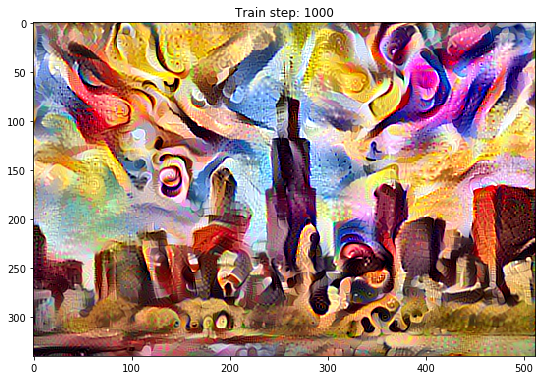

Total time: 134.2s


In [14]:
# model.py
import time
import IPython.display as display


# for demo purposes
DEMO_CONTENT = tf.keras.utils.get_file('chicago.jpg', 'https://i.imgur.com/tGnrc1a.jpg')
DEMO_STYLE = tf.keras.utils.get_file('candy.jpg', 'https://i.imgur.com/dRhrEEu.jpg')


# Content layer where we will pull our feature maps
CONTENT_LAYERS = ['block5_conv2']

# Style layer we are interested in
STYLE_LAYERS = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

style_weight = 1
content_weight = 0.4
variation_weight = 2e4

learning_rate = 10.0
epochs = 10
steps_per_epoch = 100

content_image, style_image = [load_image(
    path) for path in (DEMO_CONTENT, DEMO_STYLE)]

style_content_model = VGG19Model(CONTENT_LAYERS, STYLE_LAYERS)

image = tf.Variable(content_image)
style_targets = style_content_model(style_image)['style_outputs']
content_targets = style_content_model(content_image)['content_outputs']

opt = tf.keras.optimizers.Adam(
    learning_rate=learning_rate, beta_1=0.99, epsilon=1e-1)

style_content_model.compile(opt)

start = time.time()

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    style_content_model.fit(image,
                            content_targets=content_targets,
                            style_targets=style_targets,
                            content_layer_weights=[1],
                            style_layer_weights=[
                                1.0/len(STYLE_LAYERS)] * len(STYLE_LAYERS),
                            content_weight=content_weight,
                            style_weight=style_weight,
                            variation_weight=variation_weight)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(tf.cast(image.read_value(), tf.int32))
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}s".format(end-start))

### Converting to PIL Image

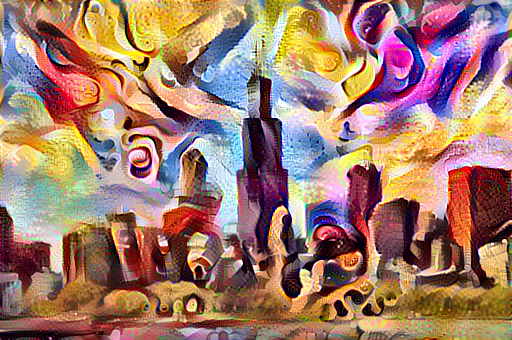

In [15]:
unsigned_image_array = tf.squeeze(image, axis=0).numpy().astype('uint8')
Image.fromarray(unsigned_image_array, 'RGB')